# Brain Tumor Detection- Keras/Pytorch 🧠🧠
* https://www.kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch
---

### data
* 
* 

## 1. Importing Modules

In [1]:
import os, glob, pathlib # 파일 위치 찾기, 입출력 등
import time, datetime, playsound # 실행 시간 측정, 완료 알림음 등
# from tqdm import tqdm # 진행 상황 표시 모듈 -> 반복문에서 현재 상태를 시각화, 진행률과 소요 시간 등 표시
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
import cv2
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.optim as optim
from torch.optim import Adam, SGD
from torch.autograd import Variable

import torchvision
from torchvision.transforms import transforms

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

## 2. Data

### 1) Loading

In [5]:
# kaggle api
# !kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

In [6]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

# print("Path to dataset files:", path)

In [36]:
END_SOUND = '../end_sound.wav'
TRAIN_PATH = '../data/brain-tumor-classification-mri/Training'
TEST_PATH = '../data/brain-tumor-classification-mri/Testing'
MODEL_SAVE_PAHT = '../model'

In [7]:
img_size = 300

In [8]:
# train dataset
train_img = []
train_label = []

tqdm_label = tqdm(os.listdir(TRAIN_PATH))
for label in tqdm_label:
    tqdm_image = tqdm(os.listdir(TRAIN_PATH+'/'+label))
    for image in tqdm_image:
        img = cv2.imread(TRAIN_PATH+'/'+label+'/'+image) # 이미지 파일 읽기 (ndarray)
        # print(type(img))
        img_resized = cv2.resize(img, (img_size, img_size)) # 이미지 크기 변경 (ndarray)
        # print(type(img_resized))
        train_img.append(img_resized)
        train_label.append(label)
    tqdm_image.close()
tqdm_label.close()

train_img = np.array(train_img) # 데이터 타입 변경 (list -> ndarray)

print('Shape of train_img:', train_img.shape)
print('Size of train_label:', len(train_label))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/822 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

Shape of train_img: (2870, 300, 300, 3)
Size of train_label: 2870


In [9]:
# test dataset
test_img = []
test_label = []

tqdm_label = tqdm(os.listdir(TEST_PATH))
for label in tqdm_label:
    tqdm_image = tqdm(os.listdir(TEST_PATH+'/'+label))
    for image in tqdm_image:
        img = cv2.imread(TEST_PATH+'/'+label+'/'+image)
        img_resized = cv2.resize(img, (img_size, img_size))
        test_img.append(img_resized)
        test_label.append(label)
    tqdm_image.close()
tqdm_label.close()

test_img = np.array(test_img)

print('Shape of test_img:', test_img.shape)
print('Size of test_label:', len(test_label))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Shape of test_img: (394, 300, 300, 3)
Size of test_label: 394


In [11]:
# label encoding -> 0: no_tumor, 1: glioma_tumor, 2: meningioma_tumor, 3: pituitary_tumor
# train_label_encoded = [0 if label=='no_tumor' else (1 if label=='glioma_tumor' else (2 if label=='meningioma_tumor' else 3)) for label in train_label]
# test_label_encoded = [0 if label=='no_tumor' else (1 if label=='glioma_tumor' else (2 if label=='meningioma_tumor' else 3)) for label in test_label]

# print('train_label_encoded 개수:', len(train_label_encoded))
# print('test_label_encoded 개수:', len(test_label_encoded))

### 2) Augmenting

In [10]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [11]:
img_datagen.fit(train_img)
img_datagen.fit(test_img)

print('Shape of train_img:', train_img.shape)
print('Shape of test_img:', test_img.shape)

Shape of train_img: (2870, 300, 300, 3)
Shape of test_img: (394, 300, 300, 3)


### 3) Visualizing

In [14]:
img_cnt = {}
for label in os.listdir(TRAIN_PATH):
    img_cnt[label] = len(os.listdir(TRAIN_PATH+'/'+label))

img_cnt

{'glioma_tumor': 826,
 'meningioma_tumor': 822,
 'no_tumor': 395,
 'pituitary_tumor': 827}

In [15]:
print(train_label.count('glioma_tumor'))
print(train_label.count('meningioma_tumor'))
print(train_label.count('no_tumor'))
print(train_label.count('pituitary_tumor'))

826
822
395
827


In [16]:
start_idx_labels = [train_label.index('no_tumor'),
                    train_label.index('glioma_tumor'),
                    train_label.index('meningioma_tumor'),
                    train_label.index('pituitary_tumor')]

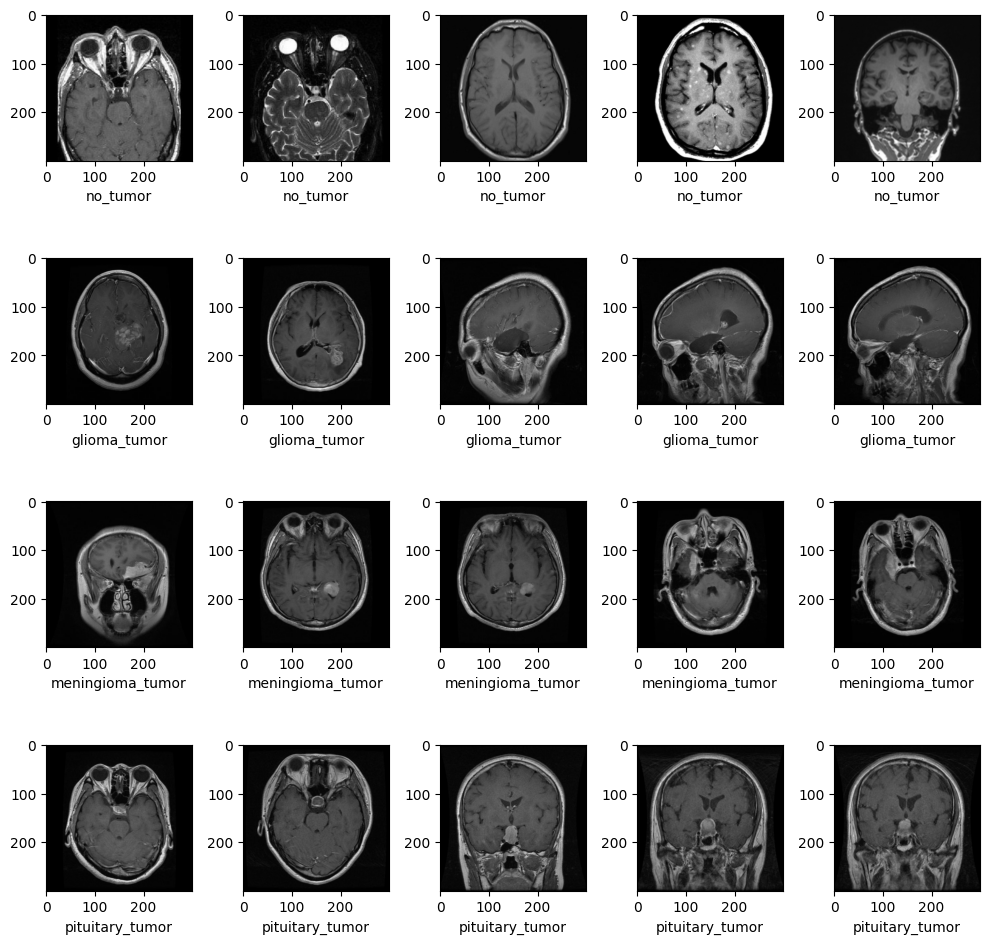

In [17]:
# train_img sample
fig, ax = plt.subplots(4, 5, figsize=(10, 10))

for i in range(4):
    for j in range(5):
        ax[i][j].imshow(train_img[start_idx_labels[i]+j])
        ax[i][j].set_xlabel(train_label[start_idx_labels[i]+j])

plt.tight_layout()
plt.show()

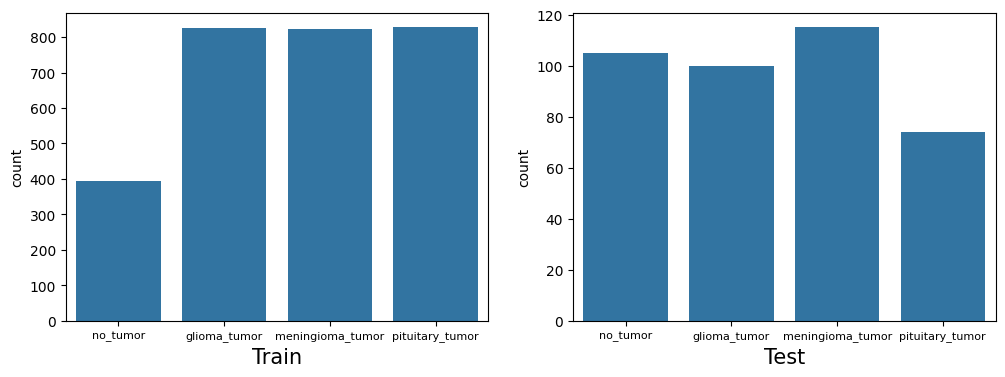

In [18]:
# label별 개수 비교
plt.figure(figsize=(12, 4))
xlabel = ['Train', 'Test']

for idx, data in enumerate([train_label, test_label]):
    plt.subplot(1, 2, idx+1)
    sns.countplot(x=data, order=['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'])
    plt.xlabel(xlabel[idx], fontsize=15)
    plt.xticks(fontsize=8)

plt.show()

## 3. Model

In [12]:
# train data split
train_x, val_x, train_y, val_y = train_test_split(train_img, np.array(train_label), test_size=0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

### 1) Baseline 

* Classification
* Tensorflow/Keras

#### epochs=20

In [20]:
# 모델 구조
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=32, activation='relu', padding='same'), # padding -> 이미지 크기 유지
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), # 이미지 크기가 절반으로 감소

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5), # 과적합 방지
    tf.keras.layers.Dense(4, activation='sigmoid')
])

In [21]:
# 모델 설정
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 모델 학습
start = time.time()

history = model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_label)), validation_split=0.1, epochs=20, verbose=1, batch_size=32)

playsound.playsound(SOUND_PAHT)
sec = time.time()-start
times = str(datetime.timedelta(seconds=sec))
print('Running Time:', times.split('.')[0])

Epoch 1/20
81/81 [==============================] - 67s 831ms/step - loss: 1.0360 - accuracy: 0.5377 - val_loss: 1.6467 - val_accuracy: 0.2509
Epoch 2/20
81/81 [==============================] - 69s 853ms/step - loss: 0.7768 - accuracy: 0.6562 - val_loss: 0.8402 - val_accuracy: 0.6760
Epoch 3/20
81/81 [==============================] - 70s 863ms/step - loss: 0.6036 - accuracy: 0.7542 - val_loss: 0.7709 - val_accuracy: 0.6620
Epoch 4/20
81/81 [==============================] - 68s 845ms/step - loss: 0.4535 - accuracy: 0.8165 - val_loss: 0.6865 - val_accuracy: 0.7526
Epoch 5/20
81/81 [==============================] - 68s 839ms/step - loss: 0.3760 - accuracy: 0.8479 - val_loss: 0.7705 - val_accuracy: 0.5645
Epoch 6/20
81/81 [==============================] - 70s 863ms/step - loss: 0.2991 - accuracy: 0.8835 - val_loss: 0.7505 - val_accuracy: 0.6237
Epoch 7/20
81/81 [==============================] - 70s 860ms/step - loss: 0.2623 - accuracy: 0.9036 - val_loss: 0.5678 - val_accuracy: 0.7178

In [103]:
print('1st CNN\'s weights shape:', model.layers[0].get_weights()[0].shape) # 첫 번재 layer의 가중치 행렬
print('2nd CNN\'s weights shape:', model.layers[2].get_weights()[0].shape)
print('3rd CNN\'s weights shape:', model.layers[4].get_weights()[0].shape)
print('4th CNN\'s weights shape:', model.layers[6].get_weights()[0].shape)
print('Output shape:', model.output_shape)

1st CNN's weights shape: (5, 5, 3, 32)
2nd CNN's weights shape: (3, 3, 32, 32)
3rd CNN's weights shape: (3, 3, 32, 32)
4th CNN's weights shape: (3, 3, 32, 64)
Output shape: (None, 4)


In [30]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(tf.cast(test_img, tf.float32), np.array(pd.get_dummies(test_label)), verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

13/13 [==============================] - 2s 139ms/step - loss: 7.7501 - accuracy: 0.7360
Test Loss: 7.7501
Test Accuracy: 0.7360


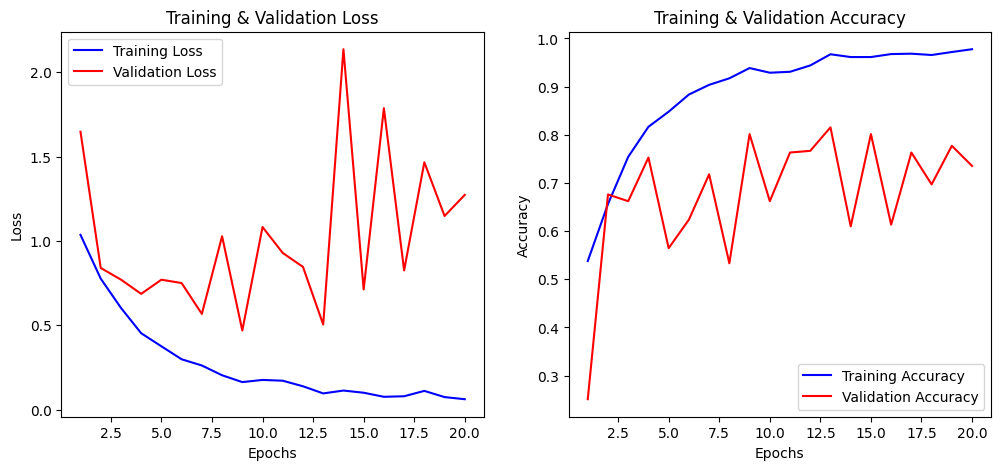

In [32]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [44]:
# 모델 저장
model.save(MODEL_SAVE_PAHT+'/practice-01_baseline_epochs-20.h5')

In [45]:
# 모델 불러오기
model = load_model(MODEL_SAVE_PAHT+'/practice-01_baseline_epochs-20.h5')

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0

#### epochs=100 (이미 학습된 모델에 재학습시켜버림)

In [47]:
# epochs=100
start = time.time()

history = model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_label)), validation_split=0.1, epochs=100, verbose=1, batch_size=32)

playsound.playsound(SOUND_PAHT)
sec = time.time()-start
times = str(datetime.timedelta(seconds=sec))
print('Running Time:', times.split('.')[0])

# 112m 55.4s

Epoch 1/100
81/81 [==============================] - 60s 727ms/step - loss: 0.0907 - accuracy: 0.9698 - val_loss: 0.8900 - val_accuracy: 0.7561
Epoch 2/100
81/81 [==============================] - 60s 747ms/step - loss: 0.1071 - accuracy: 0.9652 - val_loss: 1.2098 - val_accuracy: 0.7944
Epoch 3/100
81/81 [==============================] - 61s 750ms/step - loss: 0.0743 - accuracy: 0.9725 - val_loss: 0.6740 - val_accuracy: 0.8780
Epoch 4/100
81/81 [==============================] - 62s 764ms/step - loss: 0.0632 - accuracy: 0.9779 - val_loss: 1.1917 - val_accuracy: 0.8049
Epoch 5/100
81/81 [==============================] - 62s 770ms/step - loss: 0.0653 - accuracy: 0.9725 - val_loss: 0.3062 - val_accuracy: 0.8815
Epoch 6/100
81/81 [==============================] - 60s 737ms/step - loss: 0.0513 - accuracy: 0.9837 - val_loss: 1.4942 - val_accuracy: 0.7456
Epoch 7/100
81/81 [==============================] - 60s 738ms/step - loss: 0.0734 - accuracy: 0.9744 - val_loss: 1.1864 - val_accuracy:

ERROR:playsound:
    Error 259 for command:
        play ../end_sound.wav wait
    지정한 명령 매개 변수를 드라이버가 인식할 수 없습니다.


PlaysoundException: 
    Error 259 for command:
        play ../end_sound.wav wait
    지정한 명령 매개 변수를 드라이버가 인식할 수 없습니다.

In [48]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(tf.cast(test_img, tf.float32), np.array(pd.get_dummies(test_label)), verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

13/13 [==============================] - 2s 141ms/step - loss: 7.4557 - accuracy: 0.7310
Test Loss: 7.4557
Test Accuracy: 0.7310


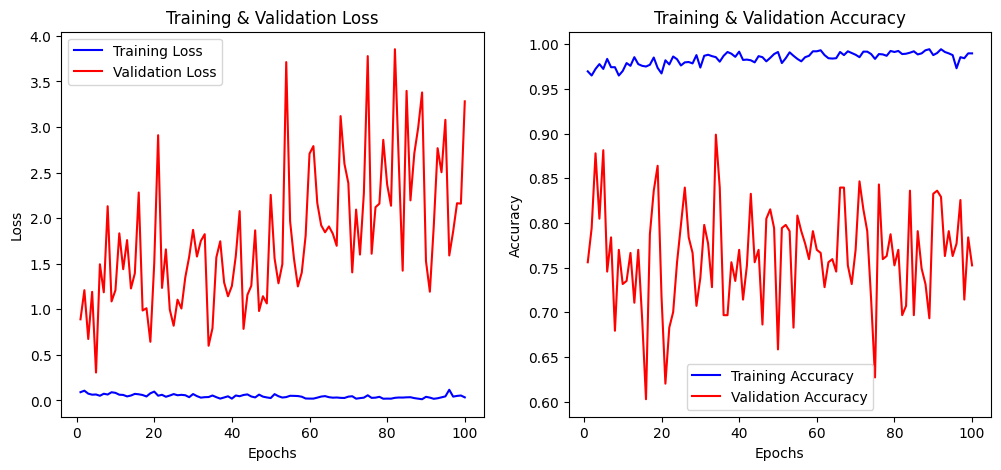

In [49]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [50]:
model.summary()

# 모델 저장
model.save(MODEL_SAVE_PAHT+'/practice-01_baseline_epochs-100.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0

#### epochs=100 (성능은 오히려 떨어짐)

In [55]:
# 다시 epochs=100

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=32, activation='relu', padding='same'), # padding -> 이미지 크기 유지
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), # 이미지 크기가 절반으로 감소

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5), # 과적합 방지
    tf.keras.layers.Dense(4, activation='sigmoid')
])

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
start = time.time()

history = model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_label)), validation_split=0.2, epochs=100, verbose=1, batch_size=32)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec))
print('-'*50)
print('Running Time:', times.split('.')[0])

Epoch 1/100
72/72 [==============================] - 67s 929ms/step - loss: 6.9129 - accuracy: 0.4713 - val_loss: 2.1949 - val_accuracy: 0.1551
Epoch 2/100
72/72 [==============================] - 66s 911ms/step - loss: 0.8224 - accuracy: 0.6307 - val_loss: 1.9440 - val_accuracy: 0.1429
Epoch 3/100
72/72 [==============================] - 66s 916ms/step - loss: 0.6729 - accuracy: 0.7017 - val_loss: 1.6214 - val_accuracy: 0.3711
Epoch 4/100
72/72 [==============================] - 66s 912ms/step - loss: 0.5309 - accuracy: 0.7757 - val_loss: 1.7585 - val_accuracy: 0.2892
Epoch 5/100
72/72 [==============================] - 65s 906ms/step - loss: 0.4389 - accuracy: 0.8232 - val_loss: 2.4483 - val_accuracy: 0.2108
Epoch 6/100
72/72 [==============================] - 61s 847ms/step - loss: 0.3858 - accuracy: 0.8349 - val_loss: 1.7707 - val_accuracy: 0.3310
Epoch 7/100
72/72 [==============================] - 61s 843ms/step - loss: 0.3240 - accuracy: 0.8802 - val_loss: 2.9285 - val_accuracy:

In [58]:
test_loss, test_accuracy = model.evaluate(tf.cast(test_img, tf.float32), np.array(pd.get_dummies(test_label)), verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

13/13 [==============================] - 2s 137ms/step - loss: 8.2859 - accuracy: 0.7081
Test Loss: 8.2859
Test Accuracy: 0.7081


In [59]:
model.summary()
model.save(MODEL_SAVE_PAHT+'/practice-01_baseline_epochs-100.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 32)      

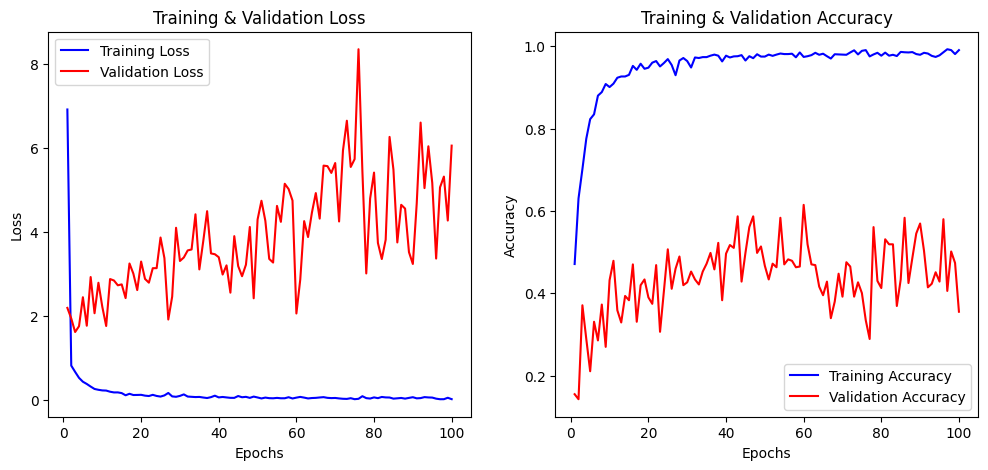

In [60]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [64]:
playsound.playsound(END_SOUND)

### 2) Baseline

* Classification
* PyTorch

In [13]:
img_size = 150

In [14]:
transforming_img = transforms.Compose([
    transforms.Resize((img_size, img_size)), # 이미지 사이즈 변경
    transforms.RandomHorizontalFlip(), # 랜덤으로 수평 뒤집기 (for 데이터 증강)
    transforms.ToTensor(), # nparray -> Tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 픽셀값 정규화 (-1 ~ 1)
])

In [20]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(TRAIN_PATH, transform=transforming_img), # 폴더 구조에 따라 자동으로 라벨링
    batch_size=64,
    shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(TEST_PATH,transform=transforming_img),
    batch_size=32,
    shuffle=True
)


In [19]:
#categories
root = pathlib.Path(TRAIN_PATH)
classes = sorted([i.name.split('/')[-1] for i in root.iterdir()])

classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [22]:
train_count = len(glob.glob(TRAIN_PATH+'/**/*.jpg'))
test_count = len(glob.glob(TEST_PATH+'/**/*.jpg'))

train_count, test_count

(2870, 394)

In [23]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        
         
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        self.fc = nn.Linear(in_features=75*75*32, out_features=num_classes)

    #Feed forwad function
    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = output.view(-1, 32*75*75)
        output = self.fc(output)
            
        return output

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

#### epochs=20

In [32]:
# 모델 설정
model = ConvNet(num_classes=4).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_function = nn.CrossEntropyLoss() # 다중클래스 분류 손실함수

In [34]:
# 모델 학습
epochs = 20

start = time.time()

best_accuracy = 0.0
for epoch in range(epochs):
    
    # 학습 모드
    model.train()

    train_accuracy, train_loss = 0.0, 0.0
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available(): # 데이터 GPU로 이동
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        optimizer.zero_grad() # 기울기 초기화
        outputs = model(images)
        loss = loss_function(outputs, labels) # 손실 함수
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
        
        train_loss += loss.cpu().data*images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction==labels.data))
        
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    
    
    # 평가 모드
    model.eval()

    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction==labels.data))
    
    test_accuracy = test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec))
print('-'*50)
print('Running Time:', times.split('.')[0])

Epoch: 0 Train Loss: tensor(2.2140) Train Accuracy: 0.7585365853658537 Test Accuracy: 0.5355329949238579
Epoch: 1 Train Loss: tensor(1.3811) Train Accuracy: 0.8170731707317073 Test Accuracy: 0.5634517766497462
Epoch: 2 Train Loss: tensor(0.4367) Train Accuracy: 0.9101045296167247 Test Accuracy: 0.6725888324873096
Epoch: 3 Train Loss: tensor(0.2789) Train Accuracy: 0.9348432055749128 Test Accuracy: 0.6624365482233503
Epoch: 4 Train Loss: tensor(0.2915) Train Accuracy: 0.9393728222996516 Test Accuracy: 0.550761421319797
Epoch: 5 Train Loss: tensor(0.3533) Train Accuracy: 0.9233449477351916 Test Accuracy: 0.6421319796954315
Epoch: 6 Train Loss: tensor(0.3482) Train Accuracy: 0.9348432055749128 Test Accuracy: 0.7030456852791879
Epoch: 7 Train Loss: tensor(0.1443) Train Accuracy: 0.964808362369338 Test Accuracy: 0.6954314720812182
Epoch: 8 Train Loss: tensor(0.2022) Train Accuracy: 0.9564459930313589 Test Accuracy: 0.6675126903553299
Epoch: 9 Train Loss: tensor(0.1183) Train Accuracy: 0.966

In [37]:
playsound.playsound(END_SOUND)


    Error 263 for command:
        open ../end_sound.wav
    지정한 장치가 열려 있지 않거나 MCI에서 인식되지 않습니다.

    Error 263 for command:
        close ../end_sound.wav
    지정한 장치가 열려 있지 않거나 MCI에서 인식되지 않습니다.
Failed to close the file: ../end_sound.wav


PlaysoundException: 
    Error 263 for command:
        open ../end_sound.wav
    지정한 장치가 열려 있지 않거나 MCI에서 인식되지 않습니다.

#### epochs=20 (다시)

In [44]:
model = ConvNet(num_classes=4).to(device)

# 모델 학습
start = time.time()

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

num_epochs = 20
for epoch in range(num_epochs):
    
    # 학습 모드
    model.train()

    train_loss, train_correct, total_samples = 0.0, 0, 0
    for images, labels in train_loader:
        if torch.cuda.is_available(): # 데이터 GPU로 이동
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad() # 기울기 초기화
        outputs = model(images)
        loss = loss_function(outputs, labels) # 손실 함수
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
        
        train_loss += loss.data*images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_correct += (prediction==labels).sum().item()
        total_samples += labels.size(0)
        
    train_loss /= total_samples
    train_accuracy = train_correct/total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    # 평가 모드
    model.eval()

    test_loss, test_correct, total_test_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
                
            outputs = model(images)
            loss = loss_function(outputs, labels)

            test_loss += loss.item()*images.size(0)
            _, prediction = torch.max(outputs, 1)
            test_correct += (prediction==labels).sum().item()
            total_test_samples += labels.size(0)
    
    test_loss /= total_test_samples
    test_accuracy = test_correct/total_test_samples
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}")

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec))
print('-'*50)
print('Running Time:', times.split('.')[0])

Epoch 1/20 - Train Loss: 1.3897, Train Accuracy: 0.2976, Val Loss: 1.4550, Val Accuracy: 0.2437
Epoch 2/20 - Train Loss: 1.3891, Train Accuracy: 0.2913, Val Loss: 1.5389, Val Accuracy: 0.2411
Epoch 3/20 - Train Loss: 1.3880, Train Accuracy: 0.2965, Val Loss: 1.5276, Val Accuracy: 0.2462
Epoch 4/20 - Train Loss: 1.3905, Train Accuracy: 0.3038, Val Loss: 1.5452, Val Accuracy: 0.2284
Epoch 5/20 - Train Loss: 1.3885, Train Accuracy: 0.3014, Val Loss: 1.5205, Val Accuracy: 0.2360
Epoch 6/20 - Train Loss: 1.3842, Train Accuracy: 0.3077, Val Loss: 1.5405, Val Accuracy: 0.2310
Epoch 7/20 - Train Loss: 1.3884, Train Accuracy: 0.3017, Val Loss: 1.5344, Val Accuracy: 0.2208
Epoch 8/20 - Train Loss: 1.3880, Train Accuracy: 0.3010, Val Loss: 1.5297, Val Accuracy: 0.2386
Epoch 9/20 - Train Loss: 1.3867, Train Accuracy: 0.3003, Val Loss: 1.5491, Val Accuracy: 0.2183
Epoch 10/20 - Train Loss: 1.3895, Train Accuracy: 0.3171, Val Loss: 1.5268, Val Accuracy: 0.2411
Epoch 11/20 - Train Loss: 1.3874, Train

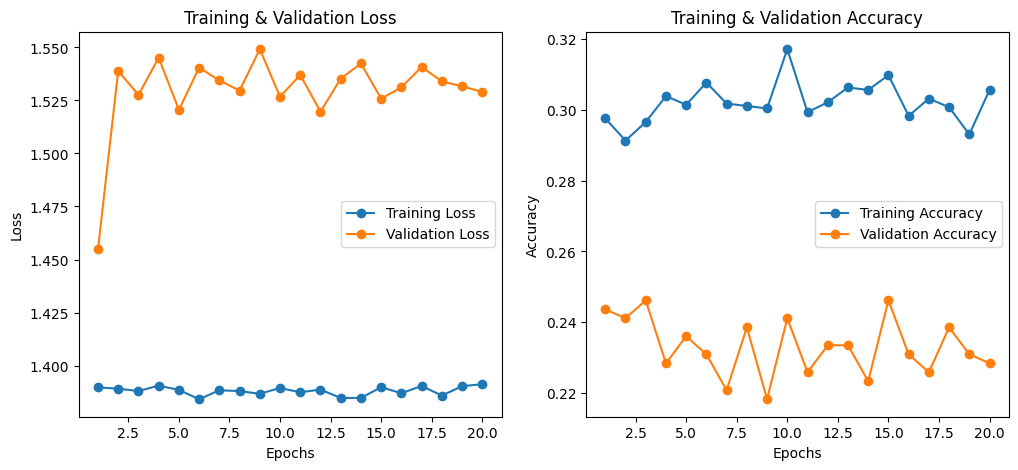

In [45]:
# CUDA 텐서를 CPU로 변환 (리스트 안에 텐서가 있다면 .cpu().numpy() 적용)
train_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_losses]
test_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in test_losses]
train_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in train_accuracies]
test_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in test_accuracies]

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs+1), test_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), test_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()

#### epochs=100

In [49]:
model = ConvNet(num_classes=4).to(device)

# 모델 학습
start = time.time()

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

num_epochs = 100
for epoch in range(num_epochs):
    
    # 학습 모드
    model.train()

    train_loss, train_correct, total_samples = 0.0, 0, 0
    for images, labels in train_loader:
        if torch.cuda.is_available(): # 데이터 GPU로 이동
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad() # 기울기 초기화
        outputs = model(images)
        loss = loss_function(outputs, labels) # 손실 함수
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
        
        train_loss += loss.data*images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_correct += (prediction==labels).sum().item()
        total_samples += labels.size(0)
        
    train_loss /= total_samples
    train_accuracy = train_correct/total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    # 평가 모드
    model.eval()

    test_loss, test_correct, total_test_samples = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
                
            outputs = model(images)
            loss = loss_function(outputs, labels)

            test_loss += loss.item()*images.size(0)
            _, prediction = torch.max(outputs, 1)
            test_correct += (prediction==labels).sum().item()
            total_test_samples += labels.size(0)
    
    test_loss /= total_test_samples
    test_accuracy = test_correct/total_test_samples
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}")

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec))
print('-'*50)
print('Running Time:', times.split('.')[0])

Epoch 1/100 - Train Loss: 1.4838, Train Accuracy: 0.2174, Val Loss: 1.4017, Val Accuracy: 0.2817
Epoch 2/100 - Train Loss: 1.4819, Train Accuracy: 0.2286, Val Loss: 1.4300, Val Accuracy: 0.2690
Epoch 3/100 - Train Loss: 1.4862, Train Accuracy: 0.2216, Val Loss: 1.4309, Val Accuracy: 0.2487
Epoch 4/100 - Train Loss: 1.4852, Train Accuracy: 0.2181, Val Loss: 1.4263, Val Accuracy: 0.2513
Epoch 5/100 - Train Loss: 1.4787, Train Accuracy: 0.2265, Val Loss: 1.4101, Val Accuracy: 0.2970
Epoch 6/100 - Train Loss: 1.4865, Train Accuracy: 0.2157, Val Loss: 1.4365, Val Accuracy: 0.2538
Epoch 7/100 - Train Loss: 1.4846, Train Accuracy: 0.2178, Val Loss: 1.4247, Val Accuracy: 0.2944
Epoch 8/100 - Train Loss: 1.4840, Train Accuracy: 0.2226, Val Loss: 1.4420, Val Accuracy: 0.2538
Epoch 9/100 - Train Loss: 1.4862, Train Accuracy: 0.2181, Val Loss: 1.4321, Val Accuracy: 0.2792
Epoch 10/100 - Train Loss: 1.4878, Train Accuracy: 0.2206, Val Loss: 1.4264, Val Accuracy: 0.2868
Epoch 11/100 - Train Loss: 1.

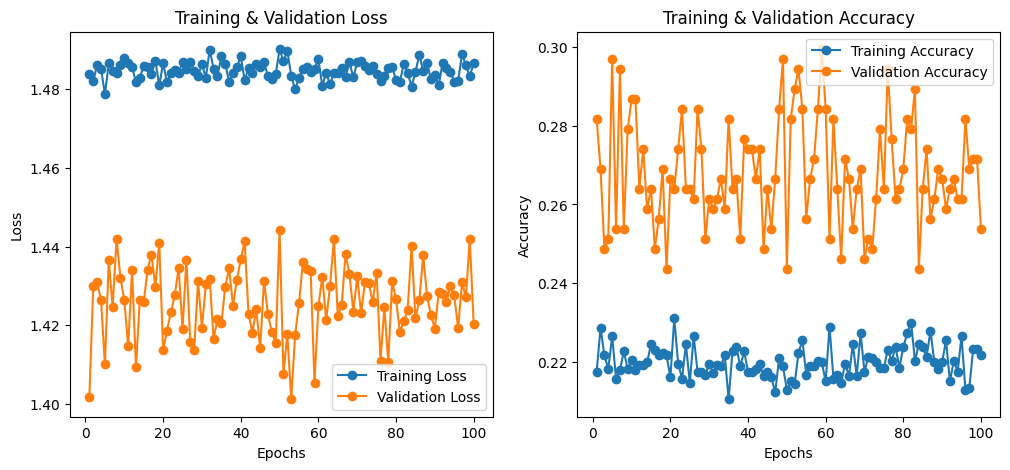

In [50]:
# CUDA 텐서를 CPU로 변환 (리스트 안에 텐서가 있다면 .cpu().numpy() 적용)
train_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_losses]
test_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in test_losses]
train_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in train_accuracies]
test_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in test_accuracies]

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs+1), test_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), test_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()